In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import MinMaxScaler

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# For SARIMA Model
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Pizza Sales

In [4]:
sale = pd.read_excel('Pizza_Sale.xlsx')
sale.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [6]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [8]:
sale.describe()

,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821494
std,14035.529381,6180.119770,0.143077,3.621789,4.437520
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


# Sales Data-Preprocessing

In [11]:
def fix_date_format(date_str):
    try:
        return pd.to_datetime(date_str, format='%m-%d-%Y')
    except ValueError:
        try:
            return pd.to_datetime(date_str, format='%d-%m-%Y')
        except ValueError:
            return pd.NaT 
            
sale['order_date'] = sale['order_date'].apply(fix_date_format)
sale['order_date'] = sale['order_date'].dt.strftime('%d-%m-%Y')
sale['order_date'] = pd.to_datetime(sale['order_date'], errors='coerce', dayfirst=True)
sale['order_time'] = pd.to_timedelta(sale['order_time'].astype(str))

In [13]:
sale.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [15]:
#sale[sale['total_price'].isnull()]
sale['total_price'].fillna(sale['quantity']*sale['unit_price'],inplace=True)

In [17]:
category_null = sale[sale['pizza_category'].isnull()]

null_pizza_details = category_null[['pizza_category', 'pizza_ingredients', 'pizza_name']]
null_pizza_details

,pizza_category,pizza_ingredients,pizza_name
426,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
431,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
432,NaN,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
433,NaN,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza
434,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
435,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [19]:
pizza_category_mapping = sale[['pizza_name', 'pizza_category']].dropna().drop_duplicates()
pizza_category_mapping = pizza_category_mapping.set_index('pizza_name')['pizza_category'].to_dict()

sale['pizza_category'] = sale['pizza_category'].fillna(sale['pizza_name'].map(pizza_category_mapping))

In [21]:
pizza_nameid_mapping = sale[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
pizza_nameid_mapping = pizza_nameid_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

sale['pizza_name_id'] = sale['pizza_name_id'].fillna(sale['pizza_name'].map(pizza_nameid_mapping))

In [23]:
pizza_ing_mapping = sale[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
pizza_ing_mapping = pizza_ing_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

sale['pizza_ingredients'] = sale['pizza_ingredients'].fillna(sale['pizza_name'].map(pizza_ing_mapping))

In [25]:
# sale.duplicated().sum() - no duplicates
sale.dropna(inplace=True)

In [27]:
sale.isnull().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [29]:
sale['year'] = sale['order_date'].dt.year
sale['month'] = sale['order_date'].dt.month_name()
sale['week'] = sale['order_date'].dt.isocalendar().week
sale['day_of_week'] = sale['order_date'].dt.day_name()

In [31]:
sale['is_weekend'] = sale['day_of_week'].isin(['Saturday', 'Sunday'])
sale['day_type'] = sale['is_weekend'].apply(lambda x: 'Weekend' if x else 'Weekday')

In [33]:
def working_hours(hour):
    if 9 <= hour < 18:
        return 'Working Hours'
    else:
        return 'Non-Working Hours'

def time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    elif 21 <= hour < 24:
        return 'Night'
    else:
        return 'Midnight'


sale['hour'] = sale['order_time'].dt.components.hours

sale['working_hours'] = sale['hour'].apply(working_hours)
sale['time_period'] = sale['hour'].apply(time_period)

In [35]:
#sale.drop(columns=['is_weekend','hour'],inplace=True)

sale.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,...,pizza_name,year,month,week,day_of_week,is_weekend,day_type,hour,working_hours,time_period
0,1,1,hawaiian_m,1,2015-01-01,0 days 11:38:36,13.25,13.25,M,Classic,...,The Hawaiian Pizza,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning
1,2,2,classic_dlx_m,1,2015-01-01,0 days 11:57:40,16.00,16.00,M,Classic,...,The Classic Deluxe Pizza,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning
2,3,2,five_cheese_l,1,2015-01-01,0 days 11:57:40,18.50,18.50,L,Veggie,...,The Five Cheese Pizza,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning
3,4,2,ital_supr_l,1,2015-01-01,0 days 11:57:40,20.75,20.75,L,Supreme,...,The Italian Supreme Pizza,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning
4,5,2,mexicana_m,1,2015-01-01,0 days 11:57:40,16.00,16.00,M,Veggie,...,The Mexicana Pizza,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning


# Pizza Ingredients

In [38]:
ingre = pd.read_excel('Pizza_ingredients.xlsx')
ingre.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [40]:
ingre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


In [42]:
ingre.describe()

,Items_Qty_In_Grams
count,514.000000
mean,30.564202
std,30.351623
min,5.000000
25%,10.000000
50%,20.000000
75%,40.000000
max,200.000000


# Ingredients Data Preprocessing

In [45]:
ingre.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [47]:
ingre[ingre['Items_Qty_In_Grams'].isnull()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [49]:
ingre[ingre['pizza_name']=='The Hawaiian Pizza'] 

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
153,hawaiian_m,The Hawaiian Pizza,Pineapple,30.0
154,hawaiian_m,The Hawaiian Pizza,Mozzarella Cheese,20.0
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN
156,hawaiian_s,The Hawaiian Pizza,Pineapple,15.0
157,hawaiian_s,The Hawaiian Pizza,Mozzarella Cheese,10.0


In [51]:
mean_qty = ingre.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()
ingre['Items_Qty_In_Grams'] = ingre['Items_Qty_In_Grams'].fillna(ingre['pizza_name_id'].map(mean_qty))

In [53]:
ingre.isnull().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

# Pizza

## Merging Sale and Ingredient Dataset

In [57]:
pizza = pd.merge(sale,ingre,on=['pizza_name_id','pizza_name'],how='left')

In [59]:
pizza.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,...,month,week,day_of_week,is_weekend,day_type,hour,working_hours,time_period,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01,0 days 11:38:36,13.25,13.25,M,Classic,...,January,1,Thursday,False,Weekday,11,Working Hours,Morning,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01,0 days 11:38:36,13.25,13.25,M,Classic,...,January,1,Thursday,False,Weekday,11,Working Hours,Morning,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01,0 days 11:38:36,13.25,13.25,M,Classic,...,January,1,Thursday,False,Weekday,11,Working Hours,Morning,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01,0 days 11:57:40,16.00,16.00,M,Classic,...,January,1,Thursday,False,Weekday,11,Working Hours,Morning,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01,0 days 11:57:40,16.00,16.00,M,Classic,...,January,1,Thursday,False,Weekday,11,Working Hours,Morning,Mushrooms,40.0


In [61]:
pizza.drop(columns=['pizza_ingredients_y'],inplace=True)
pizza = pizza.rename(columns={'pizza_ingredients_x' : 'pizza_ingredients' })

In [63]:
pizza.duplicated().sum()
pizza = pizza.drop_duplicates()

In [64]:
pizza.head(5)

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,...,year,month,week,day_of_week,is_weekend,day_type,hour,working_hours,time_period,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01,0 days 11:38:36,13.25,13.25,M,Classic,...,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning,25.0
1,1,1,hawaiian_m,1,2015-01-01,0 days 11:38:36,13.25,13.25,M,Classic,...,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning,30.0
2,1,1,hawaiian_m,1,2015-01-01,0 days 11:38:36,13.25,13.25,M,Classic,...,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning,20.0
3,2,2,classic_dlx_m,1,2015-01-01,0 days 11:57:40,16.00,16.00,M,Classic,...,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning,40.0
6,2,2,classic_dlx_m,1,2015-01-01,0 days 11:57:40,16.00,16.00,M,Classic,...,2015,January,1,Thursday,False,Weekday,11,Working Hours,Morning,10.0


In [67]:
pizza.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
year                  0
month                 0
week                  0
day_of_week           0
is_weekend            0
day_type              0
hour                  0
working_hours         0
time_period           0
Items_Qty_In_Grams    0
dtype: int64

In [69]:
pizza.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187349 entries, 0 to 267542
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   pizza_id            187349 non-null  int64          
 1   order_id            187349 non-null  int64          
 2   pizza_name_id       187349 non-null  object         
 3   quantity            187349 non-null  int64          
 4   order_date          187349 non-null  datetime64[ns] 
 5   order_time          187349 non-null  timedelta64[ns]
 6   unit_price          187349 non-null  float64        
 7   total_price         187349 non-null  float64        
 8   pizza_size          187349 non-null  object         
 9   pizza_category      187349 non-null  object         
 10  pizza_ingredients   187349 non-null  object         
 11  pizza_name          187349 non-null  object         
 12  year                187349 non-null  int32          
 13  month              

In [74]:
pizza.shape

(187349, 22)

# Exploratory Data Analysis

## Pizza name vs Quantity

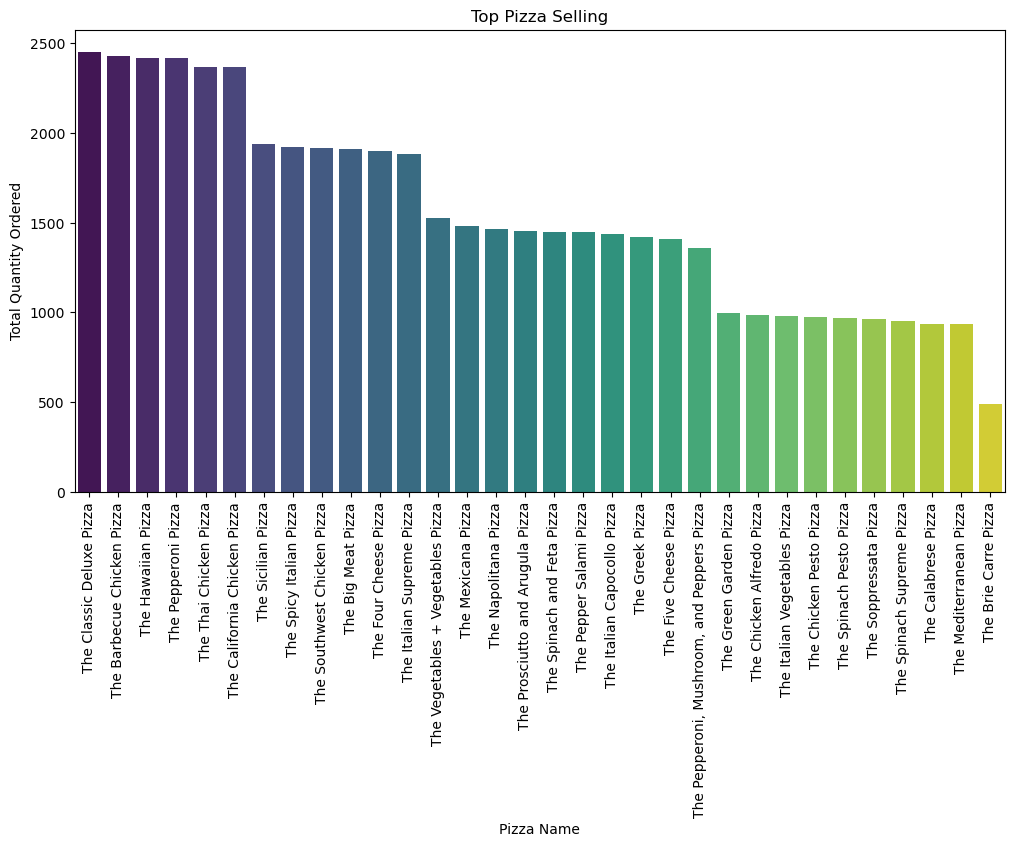

In [87]:

plt.figure(figsize=(12, 6))
pizza_qty = sale.groupby('pizza_name')['quantity'].sum().sort_values(ascending=False)
sns.barplot(x=pizza_qty.index, y=pizza_qty.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Top Pizza Selling')
plt.xlabel('Pizza Name')
plt.ylabel('Total Quantity Ordered')
plt.show()

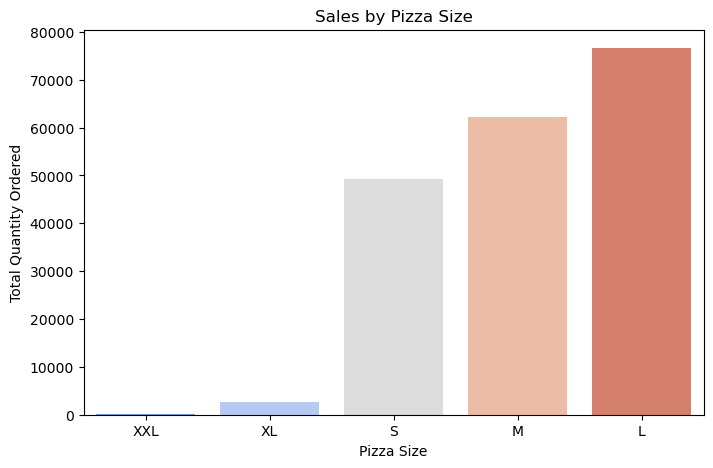

In [89]:
plt.figure(figsize=(8, 5))
size_qty = pizza.groupby('pizza_size')['quantity'].sum().sort_values()
sns.barplot(x=size_qty.index, y=size_qty.values, palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Total Quantity Ordered')
plt.show()

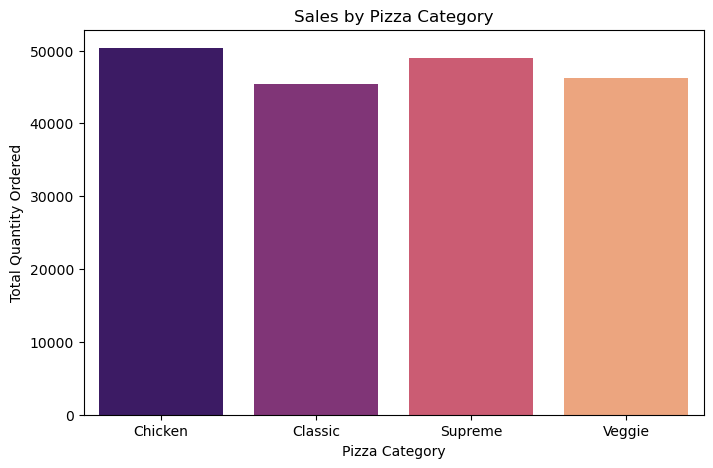

In [91]:
plt.figure(figsize=(8, 5))
category_qty = pizza.groupby('pizza_category')['quantity'].sum()
sns.barplot(x=category_qty.index, y=category_qty.values, palette='magma')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Total Quantity Ordered')
plt.show()

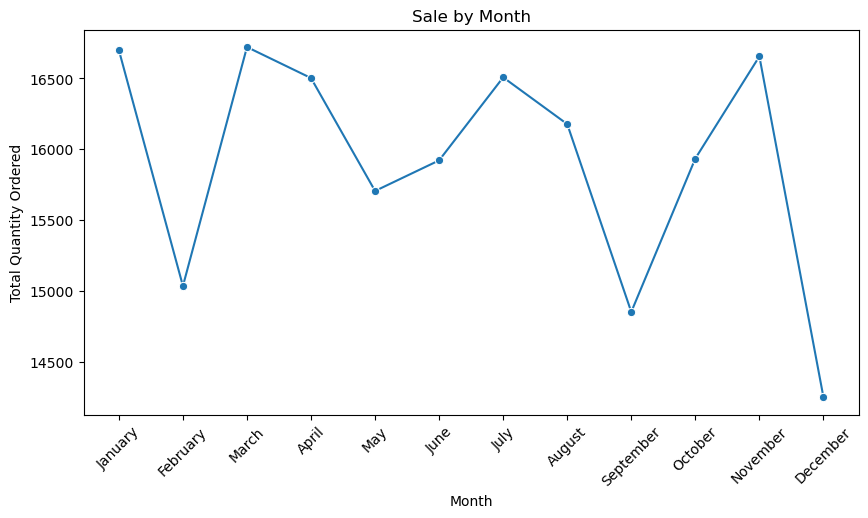

In [93]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

month_qty = pizza.groupby('month')['quantity'].sum().reindex(month_order)

plt.figure(figsize=(10, 5))
sns.lineplot(x=month_qty.index, y=month_qty.values, marker='o')
plt.title('Sale by Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.show()

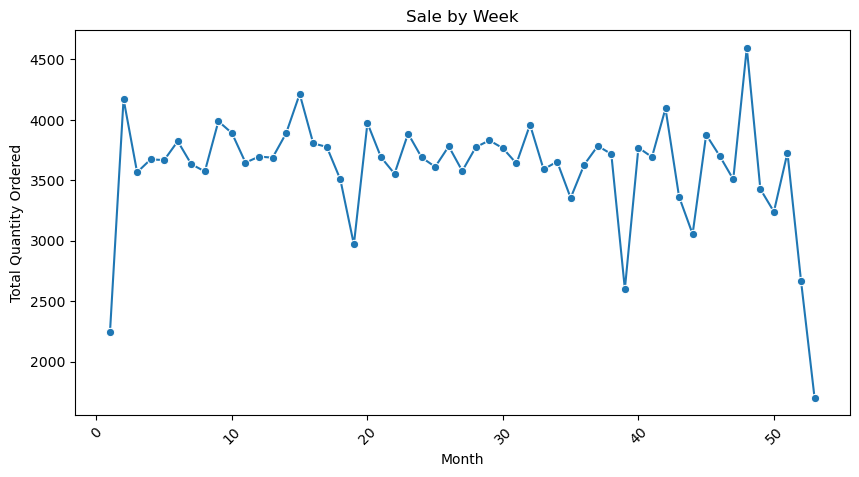

In [95]:
week_qty = pizza.groupby('week')['quantity'].sum()

plt.figure(figsize=(10, 5))
sns.lineplot(x=week_qty.index, y=week_qty.values, marker='o')
plt.title('Sale by Week')
plt.xlabel('Month')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.show()

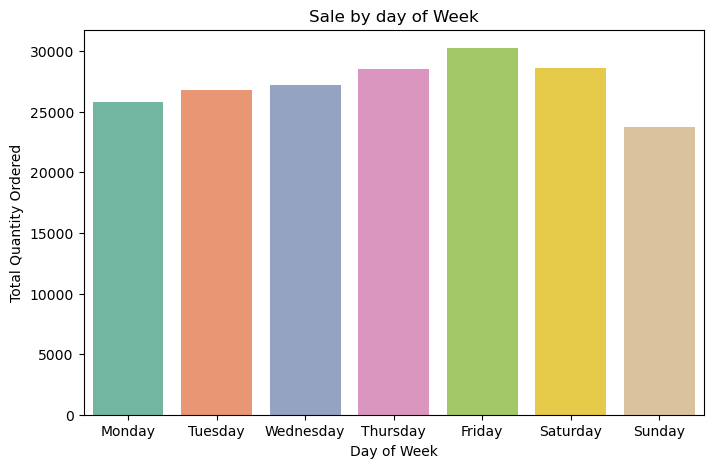

In [97]:
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_qty = pizza.groupby('day_of_week')['quantity'].sum().reindex(week_order)

plt.figure(figsize=(8, 5))
sns.barplot(x=day_qty.index, y=day_qty.values, palette='Set2')
plt.title('Sale by day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Quantity Ordered')
plt.show()

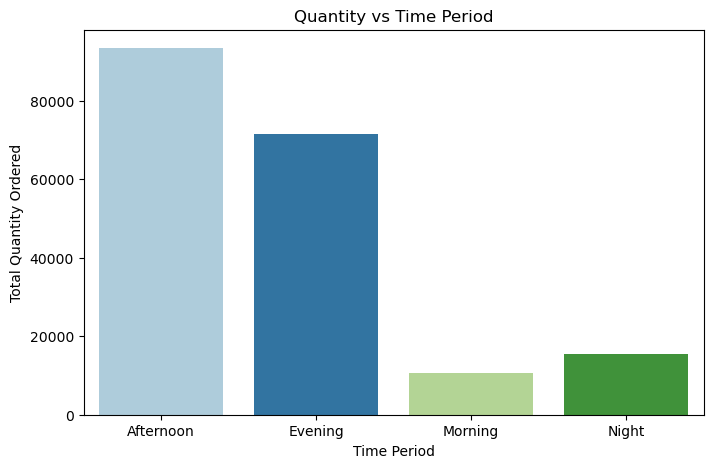

In [99]:
# Quantity vs Time Period
plt.figure(figsize=(8, 5))
time_period_qty = pizza.groupby('time_period')['quantity'].sum()
sns.barplot(x=time_period_qty.index, y=time_period_qty.values, palette='Paired')
plt.title('Quantity vs Time Period')
plt.xlabel('Time Period')
plt.ylabel('Total Quantity Ordered')
plt.show()

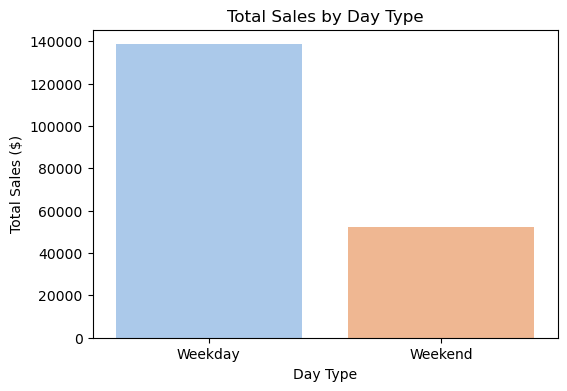

In [101]:
plt.figure(figsize=(6, 4))
day_type_sales = pizza.groupby('day_type')['quantity'].sum()
sns.barplot(x=day_type_sales.index, y=day_type_sales.values, palette='pastel')
plt.title('Total Sales by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Total Sales ($)')
plt.show()

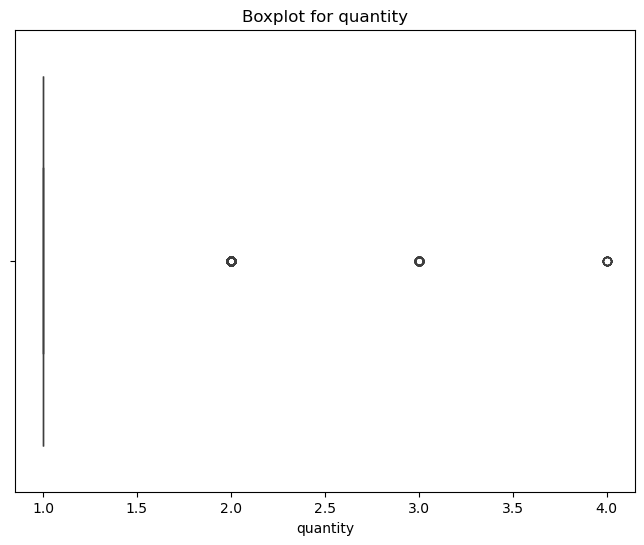

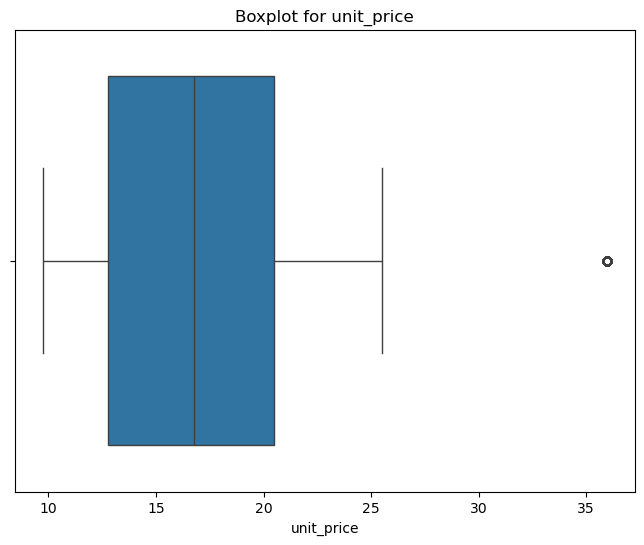

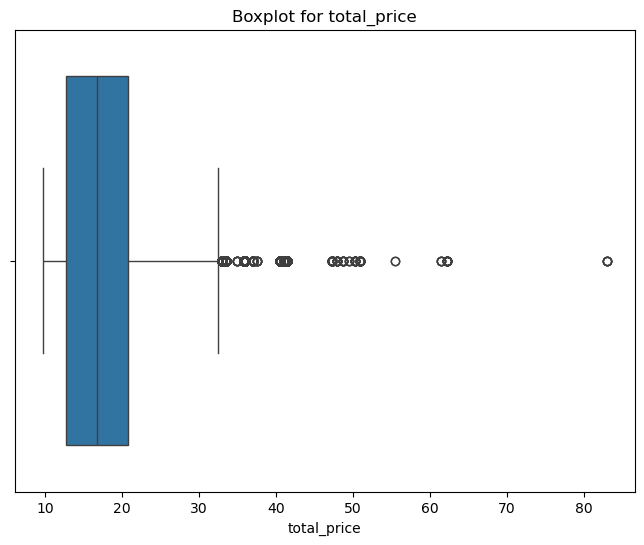

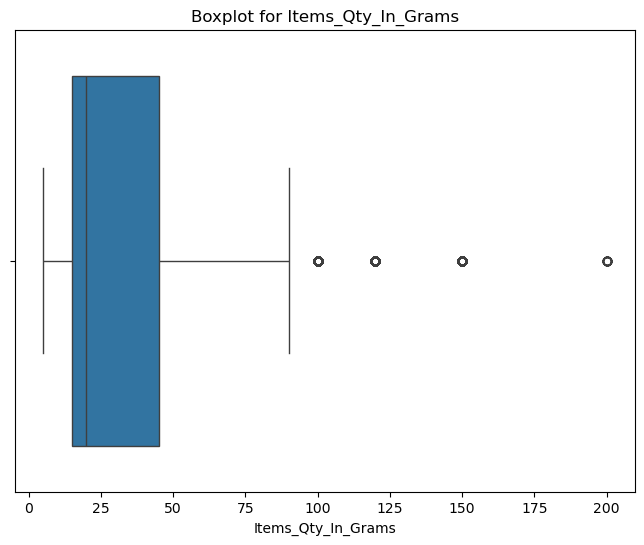

Pizza size distribution:
pizza_size
L      74902
M      61169
S      48418
XL      2720
XXL      140
Name: count, dtype: int64


In [115]:
# 3. Visualizing outliers using boxplots
def visualize_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot for {col}')
        plt.show()

# Visualize outliers for df_sales
visualize_outliers(pizza, ['quantity', 'unit_price', 'total_price','Items_Qty_In_Grams'])

# 4. Check categorical column distribution for pizza_size (df_sales)
pizza_size_counts = pizza['pizza_size'].value_counts()
print("Pizza size distribution:")
print(pizza_size_counts)


In [105]:
sales_byweek = pizza[pizza['week'] == 2]

grouped_sales = sales_byweek.groupby('pizza_name')['quantity'].sum().reset_index()
print(grouped_sales)

total_quantity_sold = sales_byweek['quantity'].sum()
print(f"\nTotal units of pizza sold in week : {total_quantity_sold} pizzas")

                                    pizza_name  quantity
0                   The Barbecue Chicken Pizza       277
1                           The Big Meat Pizza       105
2                         The Brie Carre Pizza        28
3                          The Calabrese Pizza       132
4                 The California Chicken Pizza       198
5                    The Chicken Alfredo Pizza        94
6                      The Chicken Pesto Pizza        76
7                     The Classic Deluxe Pizza       165
8                        The Five Cheese Pizza        66
9                        The Four Cheese Pizza       192
10                             The Greek Pizza       128
11                      The Green Garden Pizza       112
12                          The Hawaiian Pizza       141
13                 The Italian Capocollo Pizza       144
14                   The Italian Supreme Pizza       200
15                The Italian Vegetables Pizza        77
16                     The Medi

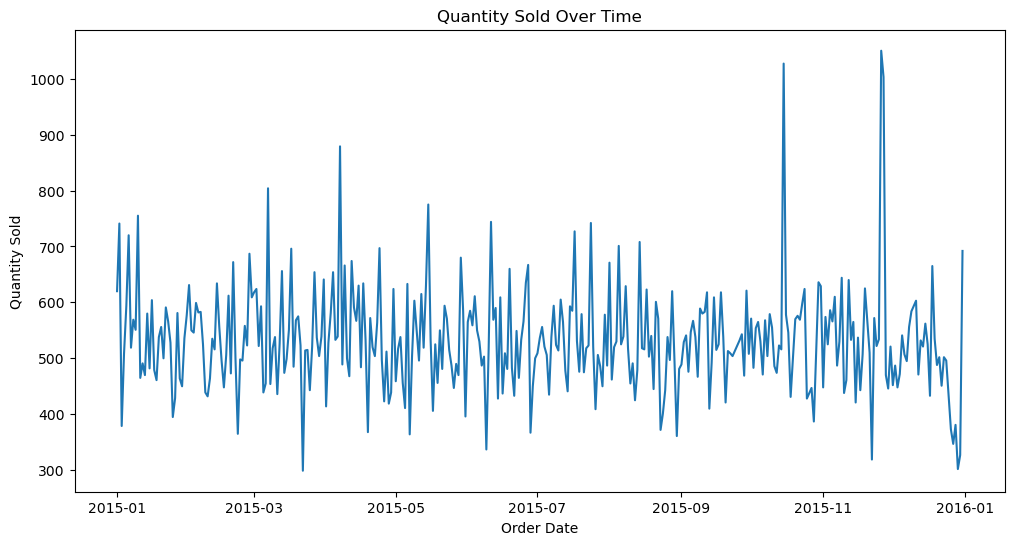

In [107]:
Sales_overdate = pizza.groupby('order_date')['quantity'].sum()

plt.figure(figsize=(12, 6))
plt.plot(Sales_overdate.index, Sales_overdate.values)
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Over Time')
plt.show()


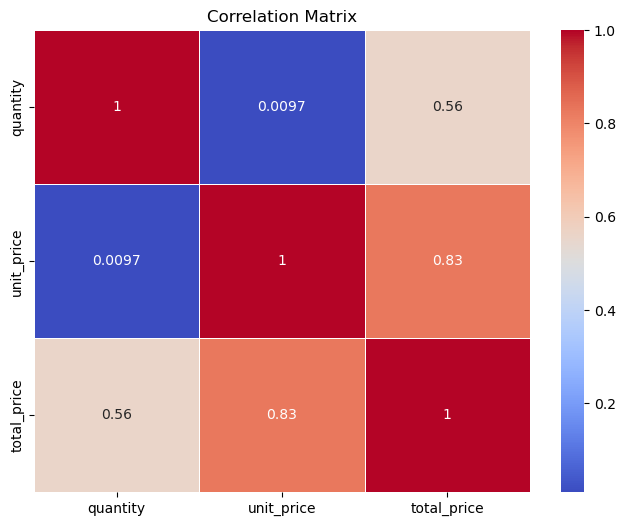

In [109]:
corr_matrix = pizza[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Model Building & Selection

## ARIMA

Best ARIMA Model MAPE: 0.1981, Best Parameters: (5, 1, 4)
Predictions:
order_date
2015-10-19    3478.288795
2015-10-26    3804.089109
2015-11-02    3629.959917
2015-11-09    3653.585717
2015-11-16    3561.934548
2015-11-23    3859.264150
2015-11-30    3535.636211
2015-12-07    3664.317673
2015-12-14    3650.101210
2015-12-21    3807.154394
2015-12-28    3471.323707
Name: predicted_mean, dtype: float64


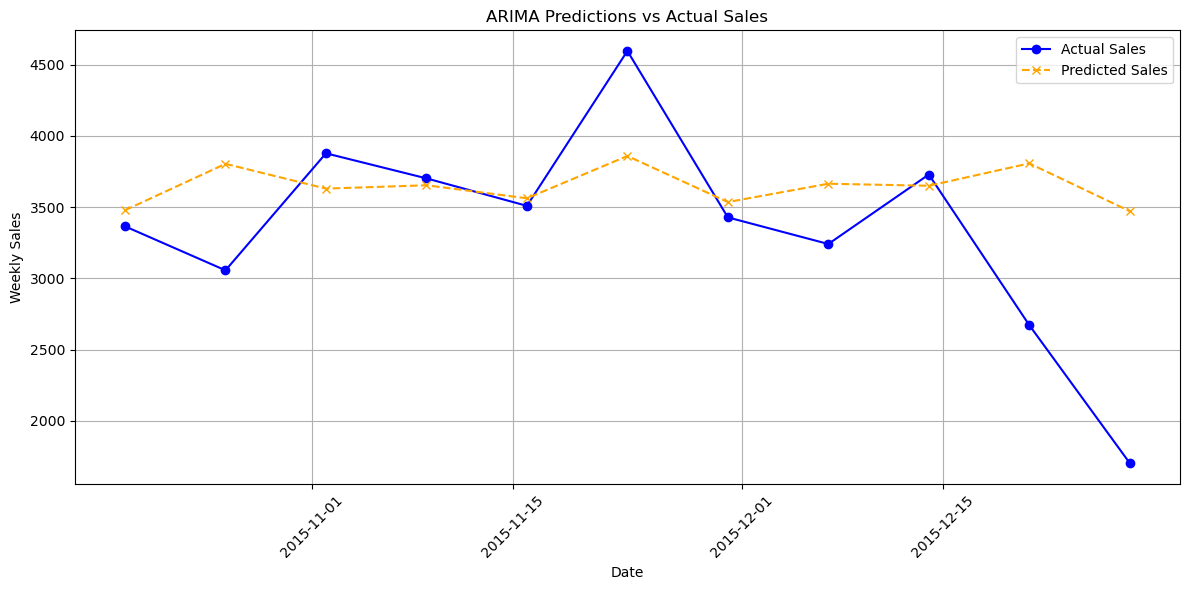

In [119]:
# Pizza sales by week
# Pizza sales by week
# Function to prepare weekly sales
# Pizza sales by week
def prepare_weekly_sales(df):
    pizza['order_date'] = pd.to_datetime(pizza['order_date'])
    weekly_sales = pizza.groupby(pizza['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# PROPHET

13:21:36 - cmdstanpy - INFO - Chain [1] start processing
13:21:36 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.2159
Predictions:
ds
2015-10-19    3682.145987
2015-10-26    3682.787191
2015-11-02    3683.428395
2015-11-09    3684.069600
2015-11-16    3684.710804
2015-11-23    3685.352008
2015-11-30    3685.993212
2015-12-07    3686.634416
2015-12-14    3687.275621
2015-12-21    3687.916825
2015-12-28    3688.558029
dtype: float64


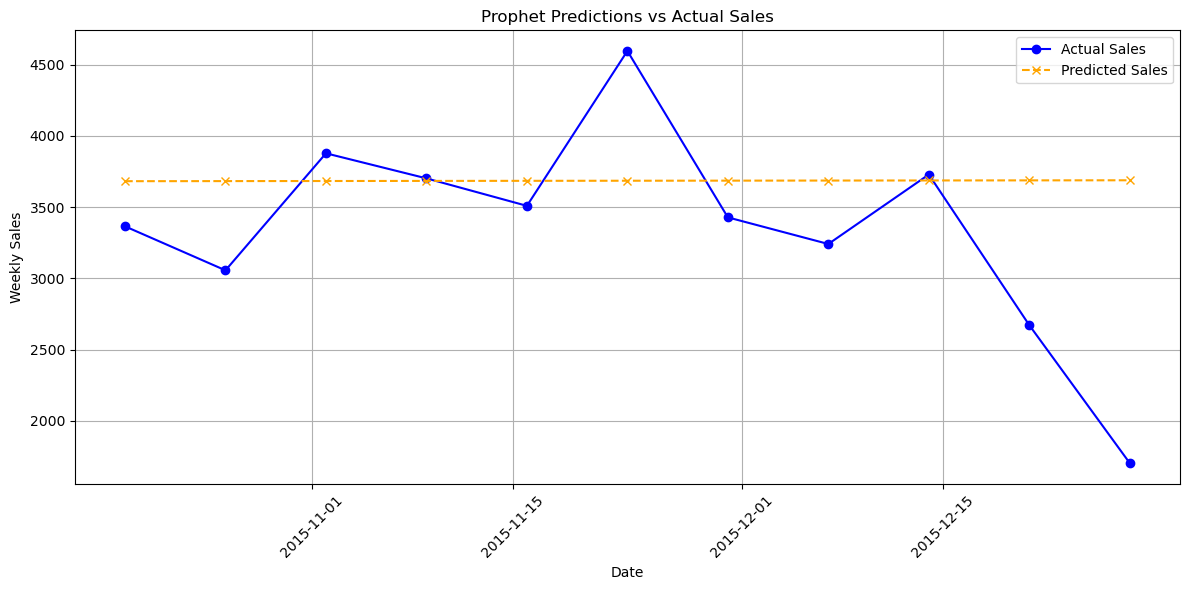

In [129]:
def prepare_weekly_sales(df):
    pizza['order_date'] = pd.to_datetime(pizza['order_date'])
    weekly_sales = pizza.groupby(pizza['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    # Resetting the index to create a DataFrame and renaming columns
    weekly_sales.columns = ['ds', 'y']  # Now 'ds' and 'y' are columns
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()

    # Fitting the model with the correctly named columns 'ds' and 'y'
    model.fit(train[['ds', 'y']]) # Pass train DataFrame to fit with proper columns

    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values

    # Ensure that test['y'] is used for calculating MAPE
    prophet_mape = mape(test['y'].values, predictions)

    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Best LSTM Model MAPE: 0.2384
Predictions:
order_date
2015-11-09    3517.280029
2015-11-16    3578.123779
2015-11-23    3717.927490
2015-11-30    3823.083984
2015-12-07    3800.518066
2015-12-14    3812.593506
2015-12-21    3543.421143
2015-12-28    3419.625977
dtype: float32


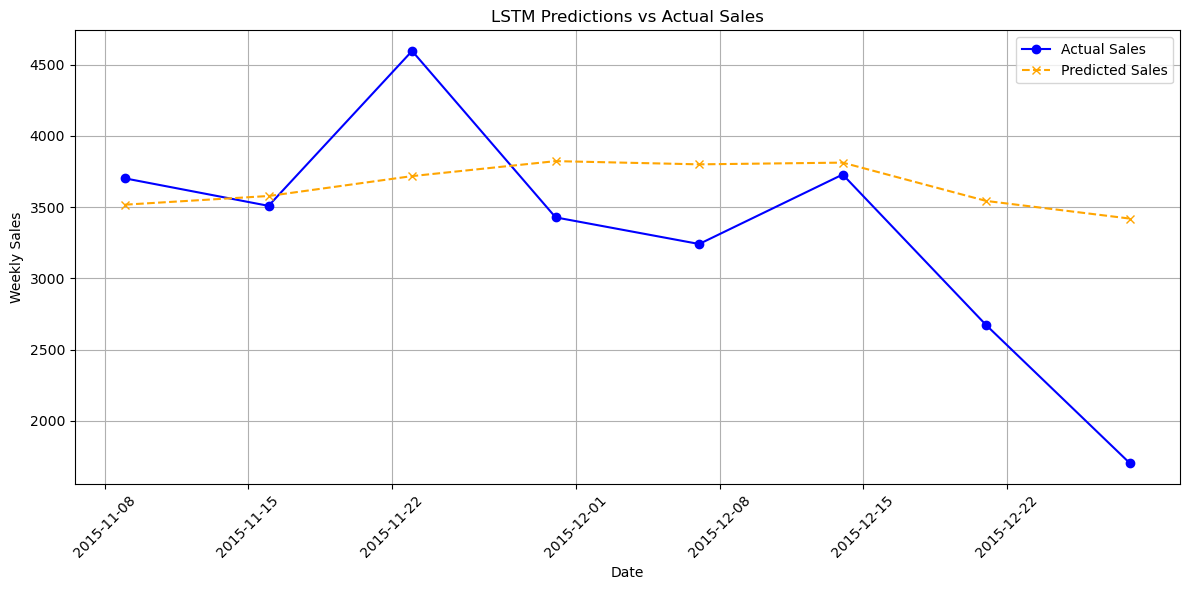

In [132]:
# Pizza sales by week
def prepare_weekly_sales(df):
    pizza['order_date'] = pd.to_datetime(pizza['order_date'])
    weekly_sales = df.groupby(pizza['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)

    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# SARIMA

New Best Model: SARIMA(0, 0, 0)x(0, 0, 0, 7) - MAPE: 1.0000
New Best Model: SARIMA(0, 0, 0)x(0, 0, 1, 7) - MAPE: 0.7612
New Best Model: SARIMA(0, 0, 0)x(0, 0, 2, 7) - MAPE: 0.6172
New Best Model: SARIMA(0, 0, 0)x(0, 0, 3, 7) - MAPE: 0.5069
New Best Model: SARIMA(0, 0, 0)x(0, 1, 0, 7) - MAPE: 0.1979
New Best Model: SARIMA(0, 0, 0)x(0, 1, 3, 7) - MAPE: 0.1876
New Best Model: SARIMA(0, 0, 0)x(0, 2, 2, 7) - MAPE: 0.1617
New Best Model: SARIMA(0, 0, 0)x(0, 2, 3, 7) - MAPE: 0.1608
New Best Model: SARIMA(0, 0, 0)x(1, 2, 1, 7) - MAPE: 0.1489
New Best Model: SARIMA(0, 0, 0)x(1, 2, 2, 7) - MAPE: 0.1398
New Best Model: SARIMA(0, 0, 1)x(1, 2, 1, 7) - MAPE: 0.1386
New Best Model: SARIMA(0, 0, 1)x(1, 2, 2, 7) - MAPE: 0.1356
New Best Model: SARIMA(0, 1, 3)x(2, 2, 2, 7) - MAPE: 0.1214

Best SARIMA Model: SARIMA(0, 1, 3)x(2, 2, 2, 7) - MAPE: 0.1214
Predictions:
order_date
2015-10-19    3733.388817
2015-10-26    3369.664913
2015-11-02    3490.627246
2015-11-09    3457.110145
2015-11-16    3551.731494
20

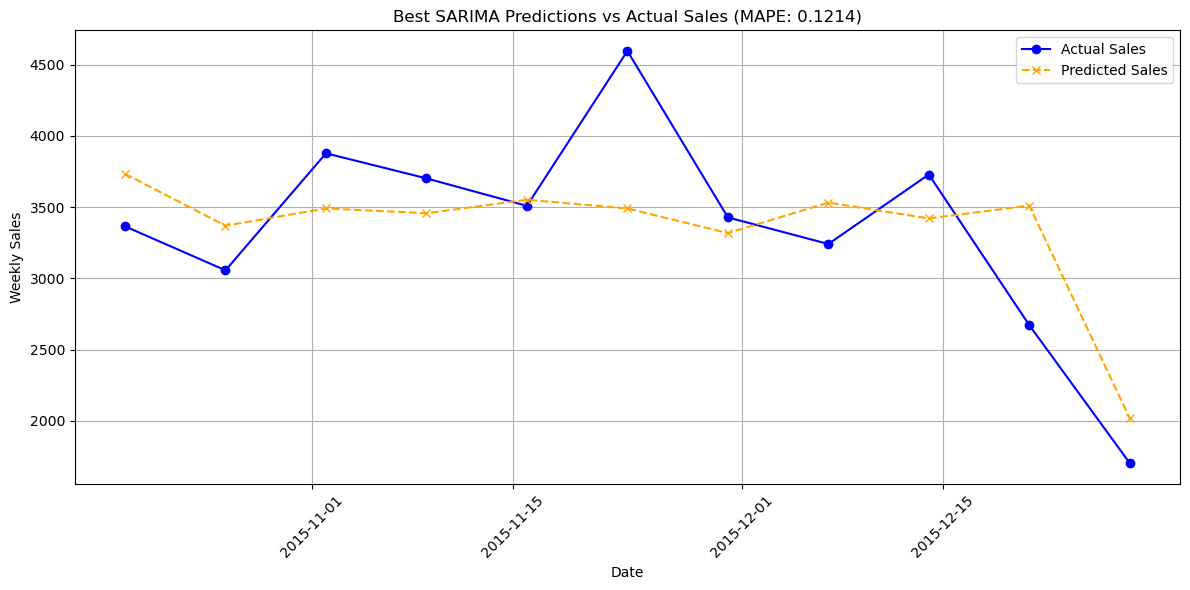

In [135]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def prepare_weekly_sales(df):
    pizza['order_date'] = pd.to_datetime(pizza['order_date'])
    weekly_sales = pizza.groupby(pizza['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Function to tune SARIMA model
def tune_sarima_model(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_score, best_params, best_predictions = float("inf"), None, None

    # Iterate through all combinations of parameters
    for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            # Fit SARIMA model
            model = SARIMAX(
                train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False,
            ).fit(disp=False)

            # Forecast and calculate MAPE
            predictions = model.forecast(steps=len(test))
            sarima_mape = mape(test, predictions)

            # Update best parameters if current model is better
            if sarima_mape < best_score:
                best_score, best_params, best_predictions = sarima_mape, (p, d, q, P, D, Q, s), predictions
                print(f"New Best Model: SARIMA{(p, d, q)}x{(P, D, Q, s)} - MAPE: {sarima_mape:.4f}")

        except Exception as e:
            continue

    print(f"\nBest SARIMA Model: SARIMA{best_params[:3]}x{best_params[3:]} - MAPE: {best_score:.4f}")
    return best_predictions, best_score, best_params

# Load and prepare data
# Assuming `pizza_sales` and `merged_data` are already loaded into the environment
pizza_sales_weekly = prepare_weekly_sales(pizza)

# Train-test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Define parameter ranges for SARIMA
p_values = range(0, 4)  # AR terms
d_values = range(0, 3)  # Differencing terms
q_values = range(0, 4)  # MA terms
P_values = range(0, 4)  # Seasonal AR terms
D_values = range(0, 3)  # Seasonal differencing terms
Q_values = range(0, 4)  # Seasonal MA terms
s = 7  # Weekly seasonality

# Tune SARIMA model
sarima_predictions, sarima_mape_score, best_params = tune_sarima_model(
    train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s
)

# Format predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)


print("Predictions:")
print(sarima_predictions)

# Display best parameters and MAPE
print(f"\nBest Parameters: {best_params}")
print(f"Best SARIMA Model MAPE: {sarima_mape_score:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title(f'Best SARIMA Predictions vs Actual Sales (MAPE: {sarima_mape_score:.4f})')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Regression

Best Regression Model MAPE: 0.1905
Predictions:
order_date
2015-10-19    3593.172142
2015-10-26    3539.501140
2015-11-02    3701.896409
2015-11-09    3648.225407
2015-11-16    3594.554406
2015-11-23    3540.883404
2015-11-30    3487.212403
2015-12-07    3649.607671
2015-12-14    3595.936670
2015-12-21    3542.265668
2015-12-28    3488.594667
dtype: float64


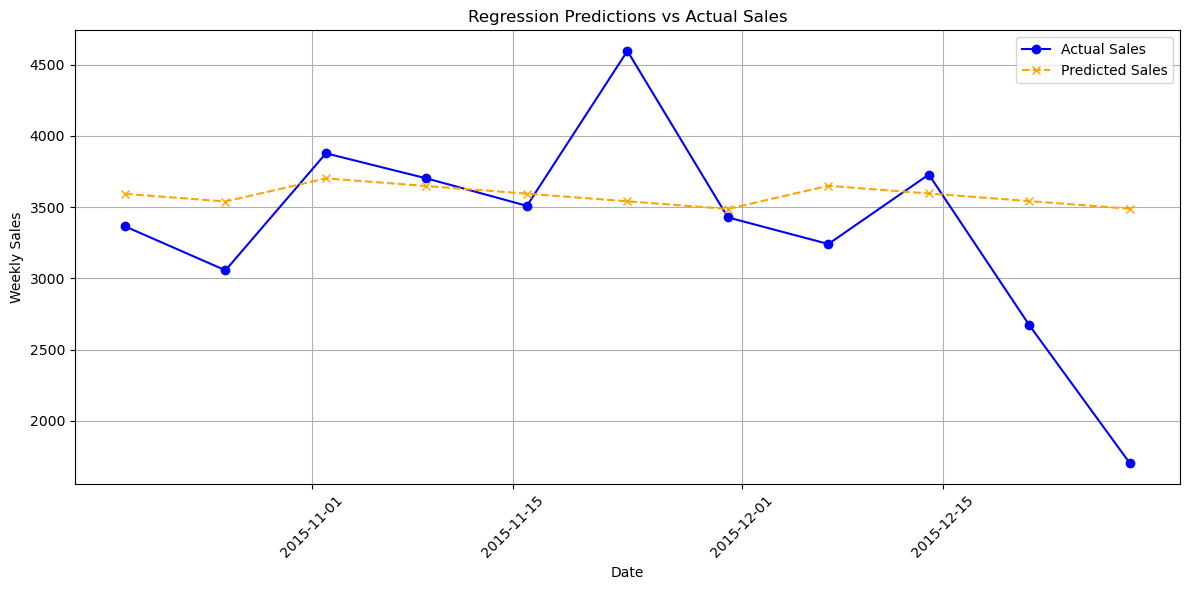

In [138]:
def prepare_weekly_sales(df):
    pizza['order_date'] = pd.to_datetime(pizza['order_date'])
    # Group by week and sum quantities and then reset index to get 'order_date' as a column
    weekly_sales = pizza.groupby(pizza['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    # Rename the grouping column to 'order_date' for consistency
    weekly_sales.columns = ['order_date', 'quantity']
    return weekly_sales

def create_regression_features(df):
    df['week'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

pizza_sales_weekly = prepare_weekly_sales(pizza)

pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Prepareing data for Regression
X_train = train[['week', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# Best Regression Model Training and Output
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)

    print(f"Best Regression Model MAPE: {regression_mape:.4f}")
    return predictions, regression_mape

# Train and evaluate the Regression model
regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

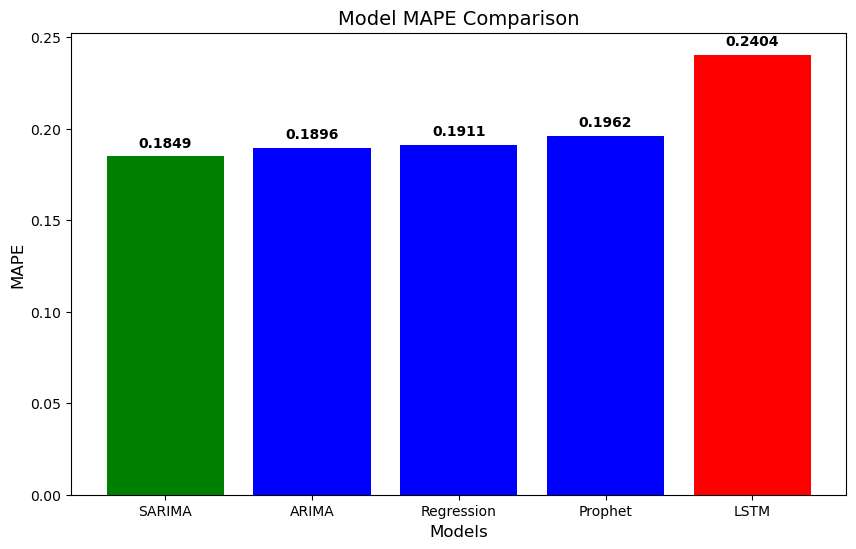

In [140]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM']
mapes = [0.1249, 0.1896, 0.1905, 0.1962, 0.2404]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'blue', 'blue', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()

# Forecasting

In [142]:
# SARIMA Model forecasted sales for the week:

# Aggregateing pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza)

# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 69 pizzas
bbq_ckn_m: 111 pizzas
bbq_ckn_s: 31 pizzas
big_meat_s: 102 pizzas
brie_carre_s: 46 pizzas
calabrese_l: 14 pizzas
calabrese_m: 35 pizzas
cali_ckn_l: 96 pizzas
cali_ckn_m: 80 pizzas
cali_ckn_s: 35 pizzas
ckn_alfredo_l: 19 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 34 pizzas
ckn_pesto_m: 17 pizzas
ckn_pesto_s: 15 pizzas
classic_dlx_l: 28 pizzas
classic_dlx_m: 66 pizzas
classic_dlx_s: 43 pizzas
five_cheese_l: 47 pizzas
four_cheese_l: 166 pizzas
four_cheese_m: 46 pizzas
green_garden_l: 6 pizzas
green_garden_m: 36 pizzas
green_garden_s: 40 pizzas
hawaiian_l: 47 pizzas
hawaiian_m: 17 pizzas
hawaiian_s: 49 pizzas
ital_cpcllo_l: 58 pizzas
ital_cpcllo_m: 44 pizzas
ital_cpcllo_s: 33 pizzas
ital_supr_l: 58 pizzas
ital_supr_m: 71 pizzas
ital_supr_s: 11 pizzas
ital_veggie_m: 41 pizzas
ital_veggie_s: 13 pizzas
mediterraneo_l: 37 pizzas
mediterraneo_m: 36 pizzas
mediterraneo_s: 24 pizzas
mexicana_l:

In [150]:
# Displaying the total quantity of predicted ingredients

# Copy ingredients, map predicted sales, and calculateing the total ingredient quantity
ingredients_predicted = ingre.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
#print(ingredient_totals)
ingredients_predicted

Total quantity of predicted ingredients for the following week:


,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,69,2760.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,69,1035.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,69,1380.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,69,2070.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,69,4140.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,35,700.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,35,700.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,35,350.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,35,525.0


In [148]:
ingredient_totals

{'?duja Salami': 2420.0,
 'Alfredo Sauce': 1405.0,
 'Anchovies': 3210.0,
 'Artichokes': 10320.0,
 'Arugula': 785.0,
 'Asiago Cheese': 6250.0,
 'Bacon': 27410.0,
 'Barbecue Sauce': 2300.0,
 'Barbecued Chicken': 6710.0,
 'Beef Chuck Roast': 16440.0,
 'Blue Cheese': 1410.0,
 'Brie Carre Cheese': 1380.0,
 'Calabrese Salami': 16350.0,
 'Capocollo': 62050.0,
 'Caramelized Onions': 736.0,
 'Chicken': 86050.0,
 'Chipotle Sauce': 7630.0,
 'Chorizo Sausage': 5100.0,
 'Cilantro': 3815.0,
 'Coarse Sicilian Salami': 11720.0,
 'Corn': 25570.0,
 'Eggplant': 2080.0,
 'Feta Cheese': 12450.0,
 'Fontina Cheese': 6390.0,
 'Friggitello Peppers': 605.0,
 'Garlic': 25015.0,
 'Genoa Salami': 8100.0,
 'Goat Cheese': 12880.0,
 'Gorgonzola Piccante Cheese': 7560.0,
 'Gouda Cheese': 4830.0,
 'Green Olives': 4885.0,
 'Green Peppers': 6570.0,
 'Italian Sausage': 1020.0,
 'Jalapeno Peppers': 6230.0,
 'Kalamata Olives': 4055.0,
 'Luganega Sausage': 5860.0,
 'Mozzarella Cheese': 12310.0,
 'Mushrooms': 25800.0,
 'Onion